#### Notes
- DATASET: Customer-level data of a leading telecom firm, 
    - Data spans over four consecutive months - June, July, August and September. 
    - First 2 months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.
- GOAL: Identify customers at high risk of churn and identify the main indicators of churn.
- Business objective: Predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

In this project 
- it is primarliy Indian and Southeast Asian market.
- the usage-based definition is used to define churn.
- High-value customers are deinfed - who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase) = 29.9k rows
- Predict churn only on high-value customers.

### Strategy followed for analysis & model building
- Data understanding and exploration
- Data pre-processing
    - Filter high-value customers
    - Tag churners and remove attributes of the churn phase
    - Derive new features
    - Impute Missing value
    - Handle Outliers
    - Create Dummy variables 
- Data Preparation
    - Test train split
    - Standardise numerical values
- Dimensionality reduction (PCA)
- Predict customers who will churn - Train a variety of models and evaluate
    - Build model and evaluate
    - Use Regularization
    - Model evaluation
    - Interpretation of the model
- Identify important predictor attributes to understand indicators of churn - Logistic regression or a model from the tree family
    - Build model and evaluate 
    - Use Regularization
    - Model evaluation
    - Interpretation of the model
- Recommend strategies to manage customer churn

#### Hints
- Using techniques to handle class imbalance - stratify
- In case of logistic regression, make sure to handle multi-collinearity.

### Imports & Functions

In [47]:
import sys

import numpy as np
import pandas as pd
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

# For data processing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings('ignore')

In [48]:
# Calculates and returns the percentage of a value in the total
def percent(value, total):
    return round(100 * value/total, 2)  

def listColumns(df):
    print(f"{len(df.columns.tolist())} {df.columns.tolist()}")

def getColumnsWithPrefix(prefix, cols):
    lenPrefix = len(prefix)
    l =list(filter(lambda x: True if x[:lenPrefix]==prefix else False,cols))
    print(len(l), l)
    return l

def getColumnsWithSuffix(suffix,cols):
    lenSuffix = len(suffix)
    l =list(filter(lambda x: True if x[-1 * lenSuffix:]==suffix else False,cols))
    print(len(l), l)
    return l
    
# Lists the columns with missing values - col name, absolute number and percentage of cells missing in the column. 
# The columns are sorted in descending order of the number of missing values.
def listColumsWithMissingData(df, LIMIT=0):
    naCols = len(df.columns[df.isna().any()])
    print(f"Columns with missing data: {naCols} {percent(naCols, len(df.columns))}%")
    cols = {}
    for col in df.columns:
        if df[col].isna().any():
            missing_count = df[col].isna().sum(),percent(df[col].isna().sum(),df.shape[0])
            #print(col, missing_count)
            if missing_count[1] < LIMIT: continue
            cols[col] = missing_count
    cols = sorted(cols.items(), key=lambda x: x[1][0], reverse=True)
    #[print(f"{col[0]:15}  {col[1][0]:7d} {col[1][1]}%") for col in cols ]
    return cols

# Displays the columns with missing data using msno matrix and bar
def displayColumnsWithMissingData(df_):
    plt.figure(figsize=(10, 6 ))
    msno.matrix(df_[df_.columns[df_.isnull().any()]]);plt.show()
    msno.bar(df_[df_.columns[df_.isnull().any()]]);plt.show()

# Gets the list of columns which are categorical in nature
def getCategoricalColumns(df):
    cat_columns_ = df.select_dtypes(include=['object']).columns.tolist()
    cat_columns = sorted(cat_columns_)
    print(f"Columns with categorical values {len(cat_columns)} --> {cat_columns}")
    return cat_columns_

# For each categorical column, 
# - prints all the unique values 
# - plots the distribution of values
def plotCategoricalVariables(df_, cat_columns, title):
    COLS = 4
    count = len(cat_columns)
    rows = count//COLS + 1
    print(count, rows)
    fig = plt.figure(figsize=(24, rows*4))
    for i in range(count):
        col = cat_columns[i]
        count_values = df_[col].unique().shape[0]
        print(f"{col:27} : [{count_values:2}] --> {sorted((df_[col].unique().tolist())) if np.NaN not in df_[col].unique().tolist() else (df_[col].unique().tolist())}")
        df__ = df_[[col]].value_counts(normalize=True)*100
        plt.subplot(rows, COLS, i+1);ax=df__.plot.bar();_ = plt.xticks(rotation=0); annotate(ax)
    fig.suptitle(title, fontsize=14)

# Gets the list of columns which are numerical in nature
def getNumericalColumns(df):
    num_columns_ = df.select_dtypes(include=[np.float, np.int64]).columns.tolist()
    num_columns_ = sorted(num_columns_)
    print(f"Columns with numerical values {len(num_columns_)} --> {num_columns_}")
    return num_columns_ 

# For each numerical column, 
# - prints all the unique values (if <30), else prints 10 values
# - plots the distribution of values - distplot (for columns with >30 unique values) or histplot (for columns with <30 unique values)
def plotNumericalVariables(df_, num_cols, title):
    COLS = 4
    count = len(num_cols)
    rows = count//COLS + 1
    print(count, rows)
    fig = plt.figure(figsize=(24, rows*4))
    for i in range(count):
        col = num_cols[i]
        count_values = df_[col].unique().shape[0]
        if count_values > 30:
            print(f"{col:26} : [{count_values:4}] --> {sorted(df[col].unique().tolist()[:10])}...{sorted(df[col].unique().tolist()[-10:])}") 
            #df_ = df[[col]].value_counts(normalize=True)*100; 
            plt.subplot(rows, COLS, i+1);sns.distplot(df_[col])
        else:
            print(f"{col:26} : [{count_values:4}] --> {sorted(df[col].unique().tolist())}") 
            #ax=df[col].plot.hist(weights=np.ones(df.shape[0]) / df.shape[0]);annotate(ax, title=col);plt.show()
            #df_ = df[[col]].value_counts(normalize=True)*100; 
            plt.subplot(rows, COLS, i+1);sns.histplot(data=df_[col])

    fig.suptitle(title, fontsize=14)

# Converts the category to a ordinal numerical label
def clategoryToOridnalLabel(X, cat):
    oe = preprocessing.OrdinalEncoder(categories=cat)
    oe.fit(X)
    print(oe.categories_)
    X1 = oe.transform(X)
    #print(X1[:5])
    return X1
    #print(oe.feature_names_in_)

# Creates dummies for categorical columns and returns the combined dataframe
# The categorical column should be dropped.
def addDummies(df, col, dropcat, df_out):
    print(f"[{col}] Before: {df_out.columns.shape[0]}", end=' ')
    temp = pd.get_dummies(df[col], prefix=col, drop_first=True)
    #df.drop(columns=[col], inplace=True)
    #temp = temp.drop([dropcat], 1)
    #Adding the results to the master dataframe
    df_out = pd.concat([df_out, temp], axis=1)
    print(f"After: {df_out.columns.shape[0]}", end=' ')
    print()
    return df_out

# Annotates the bars
def annotate(ax, title='', strformat='', divideby=1):
    # Annotate
    for p in ax.patches:
        # format(, '.1f')
        value = p.get_height()/divideby
        ax.annotate(f"{value:.1f}{strformat}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')
    ax.set_title(title)

# Read the dataset

In [49]:
df = pd.read_csv("telecom_churn_data.csv")
df.info()

In [ ]:
df.head()

In [ ]:
listColumns(df)

Do we need to handle missing values for 
- PCA?
- decision trees/random forest? 

In [ ]:
COLS= df.columns.tolist()
COLS_ID = ['mobile_number']
COLS_LOC = getColumnsWithPrefix('loc',COLS) # LOCAL
COLS_STD = getColumnsWithPrefix('std',COLS)
COLS_ISD = getColumnsWithPrefix('isd',COLS)
COLS_LAST_DATE = getColumnsWithPrefix('last_date_',COLS)
COLS_DATE = getColumnsWithPrefix('date_',COLS)
COLS_ARPU = getColumnsWithPrefix('arpu',COLS)
COLS_ONNET = getColumnsWithPrefix('onnet',COLS)
COLS_OFFNET = getColumnsWithPrefix('offnet',COLS)
COLS_ROAM = getColumnsWithPrefix('roam',COLS)
COLS_SPL = getColumnsWithPrefix('spl',COLS)
COLS_OG = getColumnsWithPrefix('og',COLS)
COLS_IC = getColumnsWithPrefix('ic',COLS)
COLS_TOTAL = getColumnsWithPrefix('total',COLS)
COLS_MAX = getColumnsWithPrefix('max',COLS)
COLS_COUNT = getColumnsWithPrefix('count',COLS)
COLS_AV = getColumnsWithPrefix('av',COLS)
COLS_VOL = getColumnsWithPrefix('vol',COLS)
COLS_NIGHT = getColumnsWithPrefix('night',COLS)
COLS_MONTH = getColumnsWithPrefix('monthly',COLS)
COLS_SACHET = getColumnsWithPrefix('sachet',COLS)
COLS_FB = getColumnsWithPrefix('fb_user',COLS)
COLS_4_MON = getColumnsWithPrefix('jun',COLS) + getColumnsWithPrefix('jul',COLS) + getColumnsWithPrefix('aug',COLS) + getColumnsWithPrefix('sep',COLS)

In [ ]:
df[COLS_LAST_DATE].head()

In [ ]:
df[COLS_DATE].head()

In [ ]:
COLS_CAT = getCategoricalColumns(df)

In [ ]:
df[COLS_CAT].head()

In [ ]:
COLS_NUM = getNumericalColumns(df)

# Filter high value customers

```High-value customers``` are those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).
After filtering the high-value customers, you should get about 29.9k rows.

In [ ]:
COLS_RECH_AMT = list(filter(lambda x: True if 'rech_amt' in x else False, COLS)); print(COLS_RECH_AMT)

In [ ]:
# Store the average recharge amount in the good phase (months 6 & 7) in the column 'avg_rech_amt_67'
df['avg_rech_amt_67'] = (df['total_rech_amt_6'] + df['total_rech_amt_7'])/2
print("Average recharge amount:");print(df[['total_rech_amt_6', 'total_rech_amt_7', 'avg_rech_amt_67']].head())

# Calculate the 70th percentile of the average recharge amount in the good phase (months 6 & 7)
PC_70_AVG_RECH_AMT = df['avg_rech_amt_67'].quantile([.7]).values[0]; print('\nPC_70_AVG_RECH_AMT:', PC_70_AVG_RECH_AMT)

# Drop all the rows with avg_rech_amt_67 below 70th eprcentile. Retain only the high value customers
print("Number of rows > PC_70_AVG_RECH_AMT:", df[df['avg_rech_amt_67']>PC_70_AVG_RECH_AMT].shape[0])
print("Number of rows >= PC_70_AVG_RECH_AMT:", df[df['avg_rech_amt_67']>=PC_70_AVG_RECH_AMT].shape[0])
df = df[df['avg_rech_amt_67']>PC_70_AVG_RECH_AMT]
print("Number of rows retained in df:", df.shape[0])

# Tag the churners

Tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are: total_ic_mou_9, total_og_mou_9, vol_2g_mb_9, vol_3g_mb_9

After tagging churners, remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).

In [ ]:
COLS_USAGE = ['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']
print(df[COLS_USAGE].shape[0])
print(df[COLS_USAGE].isnull().sum())

In [ ]:
# Find the number of rows where each of the columns are 0
df[df['total_ic_mou_9']==0].shape[0], df[df['total_og_mou_9']==0].shape[0],df[df['vol_2g_mb_9']==0].shape[0], df[df['vol_3g_mb_9']==0].shape[0]

In [ ]:
# Find all the rows where the churn columns are 0 - no calls & no mobile internet usage
CHURN_CONDITION = (df['total_ic_mou_9']==0) & (df['total_og_mou_9']==0) & (df['vol_2g_mb_9']==0) & (df['vol_3g_mb_9']==0)
df[CHURN_CONDITION].shape[0]

In [ ]:
# Tag the customers with all churn columns 0 - no calls & no mobile internet usage
COL_TARGET = 'churn'
print("Columns:", len(df.columns.tolist()), end=' --> ')
df[COL_TARGET] = 0
df.loc[CHURN_CONDITION, 'churn'] = 1
print(len(df.columns.tolist())); print((100*df[COL_TARGET].value_counts(normalize=True)).round(2))

The target variable ```churn``` is imbalanced with 91% no churn and 9% churn data points.

|   | | Predicted|  |
|---|---|---|---|
||   | 0  | 1  |
| Actual | 0 | TN   | FP  |
| | 1 |  FN |  TP |

- **False Positive (FP)**: Predicted "Churn" but was "No Churn"
- **False Negative (FN)**: Predicted "No Churn" but was "Churn" --> We would like this to be as low as possible because lot of genuine high value customers who could churn will not be addressed 

So, the evaluation metric for the classification models would be **Recall**=TP/(TP+FN)


# Explore

### Identify columns with missing data

In [ ]:
displayColumnsWithMissingData(df)
listColumsWithMissingData(df)

In [ ]:
COLS_MISS_ = listColumsWithMissingData(df, 40)
COLS_MISS = [col[0] for col in COLS_MISS_]
print("Columns with more than 40% missing data:", COLS_MISS)#;[print(col, end=', ') for col in COLS_MISS]; print()

We should drop all these columns

### Identify columns of Id type and with all same value

In [ ]:
def getDuplicateRows(df, col):
    duplcate_rows = df[df[col].duplicated()][col].shape[0]
    return duplcate_rows, percent(duplcate_rows, df.shape[0])

In [ ]:
for col in COLS_CAT:
    duplicate_rows_num, duplicate_rows_pc = getDuplicateRows(df,col)
    print(f"{col}: Duplicates {duplicate_rows_num}, {duplicate_rows_pc} Unique values: {df[col].value_counts(normalize=True).shape[0]}")

In [ ]:
print("Duplicates in mobile_number:", getDuplicateRows(df, 'mobile_number'))
print("Duplicates in circle_id:", getDuplicateRows(df, 'circle_id'))

In [ ]:
COLS_ALL_SAME_VALUE = []
COLS_LESS_UNIQUE_VALUES = []
COLS_UNIQUE = []
COLS_ID = []
for col in COLS:
    duplicate_rows_num, duplicate_rows_pc = getDuplicateRows(df,col)
    unique_values = df[col].value_counts().index.tolist()
    unique_rows_num = len(unique_values) #df[col].value_counts(normalize=True).shape[0]
    if unique_rows_num == 1:
        print(f"{col}: Duplicates {duplicate_rows_num}, {duplicate_rows_pc} Unique values: {unique_rows_num} ")
        COLS_ALL_SAME_VALUE.append(col)
    elif duplicate_rows_num == 0:
        COLS_ID.append(col)
    elif unique_rows_num < 3:
        print(f"{col}: Duplicates {duplicate_rows_num}, {duplicate_rows_pc} Unique values: {unique_rows_num} {unique_values}")
        COLS_LESS_UNIQUE_VALUES.append(col)
    #print(f"{col}: Duplicates {duplicate_rows_num}, {duplicate_rows_pc} Unique values: {df[col].value_counts(normalize=True).shape[0]}")

print();print('COLS_ID', COLS_ID)
print('COLS_ALL_SAME_VALUE', COLS_ALL_SAME_VALUE)
print('COLS_LESS_UNIQUE_VALUES', COLS_LESS_UNIQUE_VALUES)

In [ ]:
print(len(COLS_MISS), COLS_MISS)
COLS_MISS.extend(COLS_ALL_SAME_VALUE)
COLS_MISS.append('mobile_number')
print(len(COLS_MISS), COLS_MISS)

- Mobile number is unique for all rows. This should be dropped for model building.
- As all the rows for the COLS_ALL_SAME_VALUE columns have the same value. We can drop these.

### Handle Missing data

In [ ]:
print(df.shape, end='-->')
df.drop(columns=COLS_MISS, inplace=True)
print(df.shape)

In [ ]:
displayColumnsWithMissingData(df)
COLS_MISS = listColumsWithMissingData(df, 0)

### Explore

In [ ]:
COLS_ = ['vol_2g_mb', 'vol_3g_mb', 'total_ic_mou', 'total_og_mou', 'arpu']

df_0 = pd.DataFrame(columns=COLS_) 
df_1 = pd.DataFrame(columns=COLS_)
for mon in [6, 7, 8, 9]:
    for col in COLS_:
        #print(mon, f'{col}_{mon}', int(df[f'{col}_{mon}'].sum()))
        df_0.loc[f'{mon}', col] = int(df[df['churn']==0][f'{col}_{mon}'].sum()/1000)
        df_1.loc[f'{mon}', col] = int(df[df['churn']==1][f'{col}_{mon}'].sum()/1000)

COLS_USAGE_REVENUE = ['Internet Volume (TB)', 'Calls (X 10^6 minutes', 'Revenue']
df_0['Internet Volume (TB)'] = df_0['vol_2g_mb']+df_0['vol_3g_mb']
df_0['Calls (X 10^6 minutes'] = df_0['total_ic_mou']+df_0['total_og_mou']
df_0.rename(columns={'arpu':'Revenue'}, inplace=True)
df_0 = df_0[COLS_USAGE_REVENUE].transpose()

df_1['Internet Volume (TB)'] = df_1['vol_2g_mb']+df_1['vol_3g_mb']
df_1['Calls (X 10^6 minutes'] = df_1['total_ic_mou']+df_1['total_og_mou']
df_1.rename(columns={'arpu':'Revenue'}, inplace=True)
df_1 = df_1[COLS_USAGE_REVENUE].transpose()

fig = plt.figure(figsize=(20,5)); fig.suptitle("Usage of Data & calls  & Revenue over the 4 months")
ax = plt.subplot(1,2,1); ax = df_0.plot.bar(cmap='YlGnBu', ax=ax); annotate(ax, title="Churn==0"); ax.set_xticklabels(COLS_USAGE_REVENUE, rotation=0)
ax = plt.subplot(1,2,2); ax = df_1.plot.bar(cmap='YlGnBu', ax=ax); annotate(ax, title="Churn==1"); ax.set_xticklabels(COLS_USAGE_REVENUE, rotation=0)
print()

We can see that the usage and revenue falls drastically in the case of churn == 1. We may have the diff in usage and revenue as new features

In [ ]:
df_0 = df[df['churn']==0];print('df_0', df_0.shape[0])
df_1 = df[df['churn']==1];print('df_1', df_1.shape[0])

plt.figure(figsize=(15,10));plt.suptitle('Age on network - days')
ax = plt.subplot(2,2,1);sns.histplot(df_0, x='aon',ax=ax);ax.set_title("Churn==0")
ax = plt.subplot(2,2,2);sns.histplot(df_1, x='aon',ax=ax);ax.set_title("Churn==1"); print()

ax = plt.subplot(2,2,3);df_0.boxplot(column='aon', ax=ax); ax.set_title("churn==0")
ax = plt.subplot(2,2,4);df_1.boxplot(column='aon', ax=ax); ax.set_title("churn==1")

- Customers who do not churn have a typical aon of 1000 days
- Customers who churn have a typical aon of 600 days

### Understand the groups of columns

In [ ]:
listColumns(df)

In [ ]:
COLS_NOT_PRESENT = []
for col in ['loc_ic_mou_6', 
'loc_ic_t2t_mou_6', 
'loc_ic_t2m_mou_6', 
'loc_ic_t2f_mou_6', 

'loc_og_mou_6', 
'loc_og_t2t_mou_6',
'loc_og_t2m_mou_6',
'loc_og_t2f_mou_6', 
'loc_og_t2c_mou_6', 

'std_ic_mou_6', 
'std_ic_t2t_mou_6',
'std_ic_t2m_mou_6', 
'std_ic_t2f_mou_6',
'std_ic_t2o_mou_6', 

'std_og_mou_6',
'std_og_t2t_mou_6', 
'std_og_t2m_mou_6',
'std_og_t2f_mou_6', 
'std_og_t2c_mou_6', 

'isd_ic_mou_6',
'isd_og_mou_6',

'spl_ic_mou_6', 
'spl_og_mou_6', 

'ic_others_6', 
'og_others_6',

'roam_ic_mou_6',
'roam_og_mou_6',
 
'onnet_mou_6', 
'offnet_mou_6', 

'count_rech_2g_6',
'count_rech_3g_6',

'total_rech_num_6',
'total_rech_amt_6', 
'total_rech_data_6', 

'max_rech_amt_6', 
'max_rech_data_6', 

'av_rech_amt_data_6', 

'date_of_last_rech_6',  
'date_of_last_rech_data_6', 
'last_day_rch_amt_6',  
'last_date_of_month_6', 

'vol_2g_mb_6',
'vol_3g_mb_6',

'total_ic_mou_6', 
'total_og_mou_6',

'arpu_6', 

'sachet_2g_6', 
'sachet_3g_6',
'monthly_2g_6',
'monthly_3g_6', 
'night_pck_user_6', ]:
    if col not in df.columns:
        COLS_NOT_PRESENT.append(col[:-1])
        print(col)
print(COLS_NOT_PRESENT)

In [ ]:
COLS = df.columns
for col in COLS_NOT_PRESENT:
    for mon in [6, 7, 8, 9]:
        col_mon = f"{col}{mon}"
        if col_mon not in COLS:
            print(col_mon)

'loc_ic_mou_6', 
'loc_ic_t2t_mou_6', 
'loc_ic_t2m_mou_6', 
'loc_ic_t2f_mou_6', 

'loc_og_mou_6', 
'loc_og_t2t_mou_6',
'loc_og_t2m_mou_6',
'loc_og_t2f_mou_6', 
'loc_og_t2c_mou_6', 

'std_ic_mou_6', 
'std_ic_t2t_mou_6'
'std_ic_t2m_mou_6', 
'std_ic_t2f_mou_6', 

'std_og_mou_6',
'std_og_t2t_mou_6', 
'std_og_t2m_mou_6',
'std_og_t2f_mou_6', 

'isd_ic_mou_6',
'isd_og_mou_6',

'spl_ic_mou_6', 
'spl_og_mou_6', 

'ic_others_6', 
'og_others_6',

'roam_ic_mou_6',
'roam_og_mou_6',
 
'onnet_mou_6', 
'offnet_mou_6', 

'total_rech_num_6',
'total_rech_amt_6', 

'max_rech_amt_6', 

'date_of_last_rech_6',  
'last_day_rch_amt_6',  

'vol_2g_mb_6',
'vol_3g_mb_6',

'total_ic_mou_6', 
'total_og_mou_6',

'arpu_6', 

'sachet_2g_6', 
'sachet_3g_6'
'monthly_2g_6',
'monthly_3g_6', 

In [ ]:
COL_SCHEME = ['sachet_2g_6', 'sachet_3g_6','monthly_2g_6','monthly_3g_6']
print(100 * df[COL_SCHEME].isnull().sum()/df.shape[0])
for col in COL_SCHEME:
    print(col, len(df[col].unique()), df[col].unique())
df[COL_SCHEME].tail()

In [ ]:
for col in ['date_of_last_rech_6', 'last_day_rch_amt_6', ]:
    print(col, len(df[col].unique()))

In [ ]:
print(sorted(df['last_day_rch_amt_6'].unique().tolist()))
print(sorted(df['last_day_rch_amt_7'].unique().tolist()))

In [ ]:
# 'total_ic_mou_6',
COLS_IC = ['loc_ic_mou_6', 'std_ic_mou_6', 'isd_ic_mou_6','spl_ic_mou_6', 'roam_ic_mou_6']#,'ic_others_6']
df_ = df[COLS_IC+['total_ic_mou_6']].copy()
df_['total_ic'] = df_[COLS_IC].sum(axis=1)
df_.head()

In [ ]:
COLS_OG = ['loc_og_mou_6', 'std_og_mou_6', 'isd_og_mou_6','spl_og_mou_6', 'roam_og_mou_6','og_others_6']
df_ = df[COLS_OG+['total_og_mou_6']].copy()
df_['total_og'] = df_[COLS_OG].sum(axis=1)
(df_['total_og']-df_['total_og_mou_6']).head()

In [ ]:
COLS_LOC_IC = getColumnsWithPrefix('loc_ic', COLS)
COLS_LOC_IC_6 = getColumnsWithSuffix('_6', COLS_LOC_IC)
df_ = df[COLS_LOC_IC_6].copy()
df_['total_loc_ic'] = df_[['loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6','loc_ic_t2f_mou_6']].sum(axis=1)
df_.head()

- 'loc_ic_mou_6' is sum of 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6','loc_ic_t2f_mou_6'. So should we drop the rest of the columns?

In [ ]:
COLS_LOC_STD = getColumnsWithPrefix('std_og', COLS)
COLS_LOC_STD_6 = getColumnsWithSuffix('_6', COLS_LOC_STD)
df_ = df[COLS_LOC_STD_6].copy()
df_['total_std_og'] = df_[['std_og_t2t_mou_6', 'std_og_t2m_mou_6','std_og_t2f_mou_6']].sum(axis=1)
df_.head()

In [ ]:
# ONNET
# 'onnet_mou_6',
COLS_ONNET = [
        'loc_ic_t2t_mou_6', 'loc_ic_t2f_mou_6', 
        'loc_og_t2t_mou_6', 'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6',
        'std_ic_t2t_mou_6', 'std_ic_t2f_mou_6',
        'std_og_t2t_mou_6','std_og_t2f_mou_6', 
        ]
COLS_ONNET_6 = getColumnsWithSuffix('_6', COLS_ONNET)
df_ = df[COLS_ONNET_6 + ['onnet_mou_6']].copy()
df_['total_onnet'] = df_[COLS_ONNET_6].sum(axis=1)
df_.head()

In [ ]:
# OFFNET
df[['offnet_mou_6', 'loc_ic_t2m_mou_6', 'loc_og_t2m_mou_6', 'std_ic_t2m_mou_6', 'std_og_t2m_mou_6',]].head()

In [ ]:
# Check if all the months have equal number of columns
getColumnsWithSuffix('_6', COLS);getColumnsWithSuffix('_7', COLS);getColumnsWithSuffix('_8', COLS);getColumnsWithSuffix('_9', COLS);print()

# Remove the month 9 columns

In [ ]:
COLS_MONTH_9 = getColumnsWithSuffix('_9', COLS)
print(len(COLS), end=' --> ')
COLS = list(set(COLS) - set(COLS_MONTH_9))
print(len(COLS))
df = df[COLS]

In [ ]:
displayColumnsWithMissingData(df)
COLS_MISS = listColumsWithMissingData(df, 0)

In [ ]:
COLS_MISS

In [ ]:
COLS_CAT = getCategoricalColumns(df)
plotCategoricalVariables(df, COLS_CAT, "")

Columns with numerical values 127 --> ['aon', 'arpu_6', 'arpu_7', 'arpu_8', 'aug_vbc_3g', 'avg_rech_amt_67', 'churn', 'ic_others_6', 'ic_others_7', 'ic_others_8', 'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'jul_vbc_3g', 'jun_vbc_3g', 'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'monthly_3g_6', 'monthly_3g_7

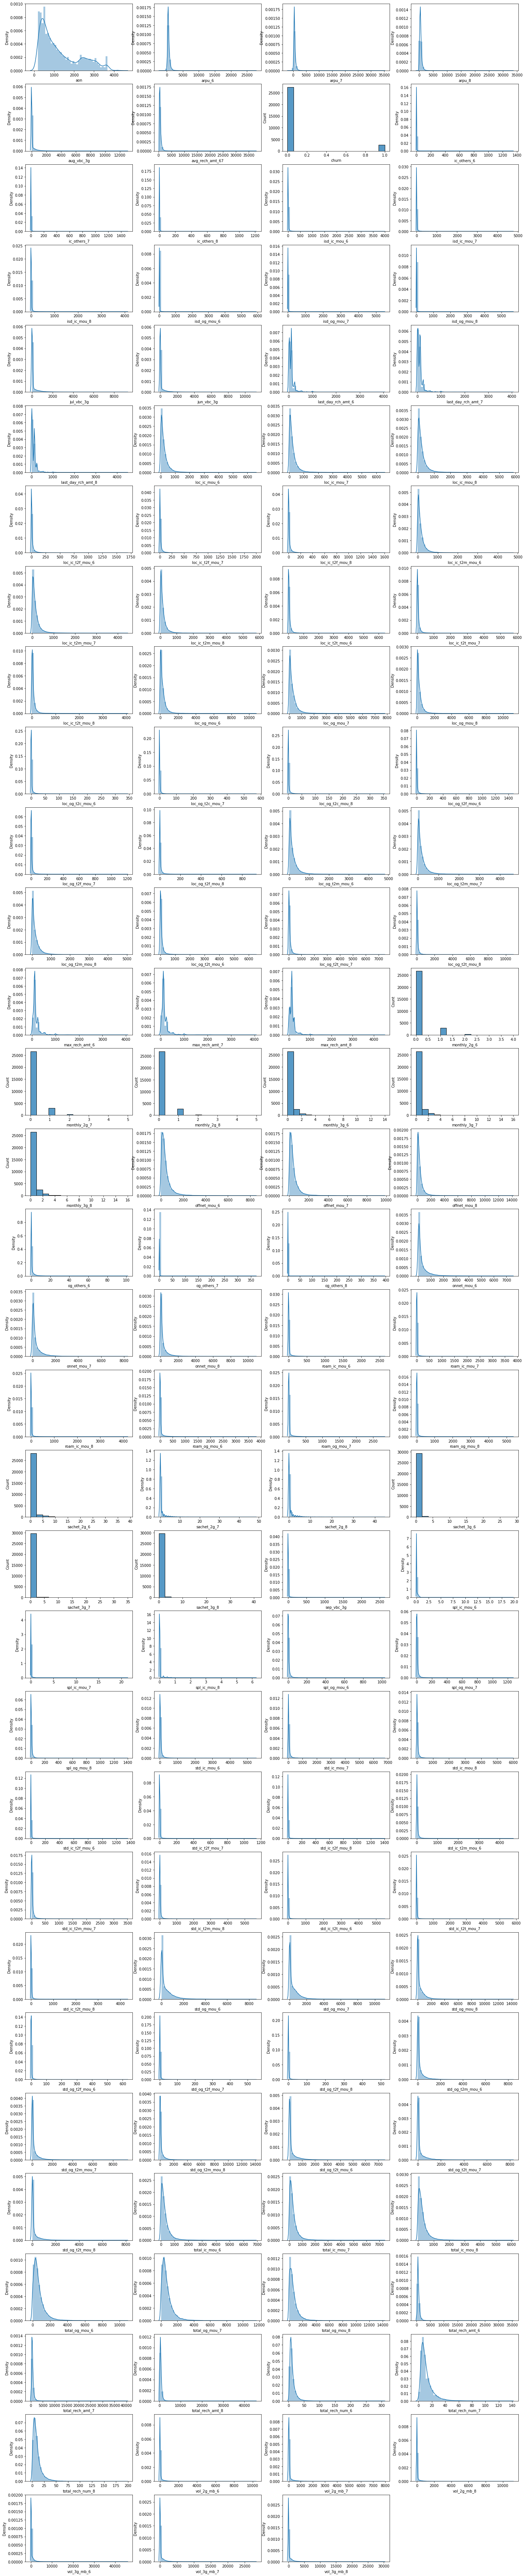

In [46]:
COLS_NUM = getNumericalColumns(df)
plotNumericalVariables(df, COLS_NUM, "")

# Derive new features

1. avg_rech_amt_67: average average recharge amount in the good phase (months 6 & 7)
2. 'vol_mb_67', 'vol_mb_78': Difference in the internet usage between the months 6,7 & 8
3. 'total_mou_67', 'total_mou_78': Difference in the calls between the months 6,7 & 8
4. 'arpu67', 'arpu_78': Difference in the revenue between the months 6,7 & 8

# Pre-process data
- Impute Missing value
- Handle Outliers
- Create Dummy variables 

## Prepare data

# Model to predict customers who will churn - with PCA

# Model to identify indicators of churn - w/o PCA